In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 16)
!date

%load_ext autoreload
%autoreload 2

Sun Mar  8 08:07:47 PDT 2020


# Supplementary Appendix Calcs for Census DP E2E Paper (part 2)

EPL is capable of producing evidence that the bounds in the sequential composition theorem are not tight, as well.  As a minimal example of how this can happen, we add a little complexity to our simple demonstration example, by including a measurement of the total count in each enumeration district with epsilon1 and the measurements of the stratified counts in each enumeration district with epsilon2.  Inspired by the optimization step of TopDown, we then use optimization to find consistent values for the detailed counts that minimize the weighted sum of the absolute differences between the measured values and the optimized values [[equation here]].  This is epsilon1+epsilon2-DP because of sequential composition, but the EPL can be substantially smaller than this sum as shown in [[table of e1, e2, epl]].

In [2]:
import dp_2020_census.data, dp_2020_census.model

In [3]:
df_orig = dp_2020_census.data.load_orig_counts()

In [4]:
df_orig

,state,county,enum_dist,gq,age,race,eth,count
0,2,3000,10,1,18,1,1,85
1,2,3000,10,1,17,1,1,7
2,2,3000,10,1,18,2,1,1
3,2,3000,10,1,18,3,1,1
4,2,3000,10,1,17,3,1,3
...,...,...,...,...,...,...,...,...
825431,56,450,160,1,17,1,1,68
825432,56,450,160,1,18,1,2,1
825433,56,455,10,1,18,1,1,325
825434,56,455,10,1,17,1,1,87


In [5]:
total_cnt_orig = df_orig[(df_orig.state == 53)].groupby(['state', 'county', 'enum_dist'])['count'].sum()
total_cnt_orig

state  county  enum_dist
53     10      10            348
               20            227
               30             79
               40            121
               50            181
                            ... 
       770     1330         1642
               1340         1157
               1350         1378
               1360          145
               1370          415
Name: count, Length: 2663, dtype: int64

In [6]:
stratification_cols = ['state', 'age', 'race', 'eth']
col_vals = []
for col in stratification_cols:
    col_vals.append(df_orig[(df_orig.state == 53)][col].unique())

In [7]:
col_vals

[array([53]), array([18, 17]), array([1, 5, 2, 6, 3, 4]), array([1, 2])]

In [8]:
t = df_orig[(df_orig.state == 53)].groupby(['state', 'county', 'enum_dist', 'age', 'race', 'eth'])['count'].sum().reset_index()
t

,state,county,enum_dist,age,race,eth,count
0,53,10,10,17,1,1,139
1,53,10,10,18,1,1,209
2,53,10,20,17,1,1,62
3,53,10,20,18,1,1,165
4,53,10,30,17,1,1,19
...,...,...,...,...,...,...,...
9864,53,770,1360,18,1,1,105
9865,53,770,1370,17,1,1,105
9866,53,770,1370,17,1,2,1
9867,53,770,1370,18,1,1,307


In [9]:
t = pd.merge(total_cnt_orig.reset_index(),
             pd.Series(0, index=pd.MultiIndex.from_product(col_vals, names=stratification_cols)).reset_index(),
             on='state', how='outer')
all_zeros = t.groupby(['state', 'county', 'enum_dist', 'age', 'race', 'eth'])[0].sum()

In [10]:
strat_cnt_orig = df_orig[(df_orig.state == 53)].groupby(['state', 'county', 'enum_dist', 'age', 'race', 'eth'])['count'].sum()
strat_cnt_orig = strat_cnt_orig.add(all_zeros, fill_value=0)
strat_cnt_orig

state  county  enum_dist  age  race  eth
53     10      10         17   1     1      139.0
                                     2        0.0
                               2     1        0.0
                                     2        0.0
                               3     1        0.0
                                            ...  
       770     1370       18   4     2        0.0
                               5     1        0.0
                                     2        0.0
                               6     1        0.0
                                     2        0.0
Length: 63912, dtype: float64

In [11]:
# set randoms seed for reproducibility
np.random.seed(12345)

In [12]:
epsilon_1 = 0.25
total_cnt_gdpc = dp_2020_census.model.GDPC(epsilon_1/2, total_cnt_orig)
total_cnt_gdpc

state  county  enum_dist
53     10      10            356
               20            225
               30             56
               40            122
               50            185
                            ... 
       770     1330         1651
               1340         1153
               1350         1375
               1360          146
               1370          401
Name: count, Length: 2663, dtype: int64

In [13]:
epsilon_2 = 0.75
strat_cnt_gdpc = dp_2020_census.model.GDPC(epsilon_2/2, strat_cnt_orig)
strat_cnt_gdpc

state  county  enum_dist  age  race  eth
53     10      10         17   1     1      139.0
                                     2        8.0
                               2     1        0.0
                                     2       -3.0
                               3     1        2.0
                                            ...  
       770     1370       18   4     2        0.0
                               5     1        0.0
                                     2       -1.0
                               6     1       -1.0
                                     2        5.0
Length: 63912, dtype: float64

In [14]:
strat_cnt_gdpc[53,10,10]

age  race  eth
17   1     1      139.0
           2        8.0
     2     1        0.0
           2       -3.0
     3     1        2.0
                  ...  
18   4     2       -2.0
     5     1        2.0
           2        0.0
     6     1        0.0
           2        1.0
Length: 24, dtype: float64

In [15]:
import pyomo.environ
from pyomo.core import *
from pyomo.opt import SolverFactory

In [16]:
def nonneg_optimized_counts(total_counts, strat_counts):
    """optimize the stratified counts so that they are consistent with the control total and are non-negative
    
    Parameters
    ----------
    total_counts : pd.Series of floats
    strat_counts : pd.Series of floats
    
    Results
    -------
    returns optimized_total_counts, where noisy counts are optimized
    to be close to total and stratified counts and not be negative
    """
    
    model = ConcreteModel()
    model.I = range(len(strat_counts))

    model.x = Var(model.I, within=NonNegativeReals, initialize=0)
    
    model.tc = []
    obj_expr_list = []
    for i, df_i in strat_counts.reset_index().groupby(['state', 'county', 'enum_dist']):
        model.tc.append(sum(model.x[ii] for ii in df_i.index))
        obj_expr_list.append(.25*(sum(model.x[ii] for ii in df_i.index) - total_counts[i])**2)
        for ii in df_i.index:
            obj_expr_list.append(.75*(model.x[ii] - strat_counts.iloc[ii])**2)
    model.objective = Objective(expr = sum(obj_expr_list))
    
    solver = SolverFactory('ipopt')
    options = {#'acceptable_tol':.01, # https://www.coin-or.org/Bonmin/option_pages/options_list_ipopt.html
#                'resto_failure_feasibility_threshold': 1e-3,
#                'bound_push':1e-9,  # from https://list.coin-or.org/pipermail/ipopt/2013-April/003319.html
#                'bound_frac':1e-9, # as above
#                'report_mininfeas_solution': 'yes', # from http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.589.5002&rep=rep1&type=pdf
              }
    results = solver.solve(model, options=options, tee=False)
    optimized_counts = np.array([value(tc_i) for tc_i in model.tc])
        
    return optimized_counts
nonneg_optimized_counts(total_cnt_gdpc, strat_cnt_gdpc.iloc[:100])

array([359.85714294, 230.62500011,  70.5714287 , 130.33333342,
       131.        ])

In [17]:
%%time

total_cnt_opt = nonneg_optimized_counts(total_cnt_gdpc, strat_cnt_gdpc)
total_cnt_opt.shape

CPU times: user 12.5 s, sys: 236 ms, total: 12.8 s
Wall time: 19.1 s


In [18]:
error = total_cnt_opt - total_cnt_orig
df_epl = dp_2020_census.model.empirical_privacy_loss(
    error, bandwidth=0.1, est_range_percentile=95, est_range_multiplier=1.0)

/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:85: RuntimeWarning: divide by zero encountered in log
  df['epl_cusum'] = np.log(ccusum[1:] / ccusum[:-1])


In [19]:
epsilon = epsilon_1 + epsilon_2

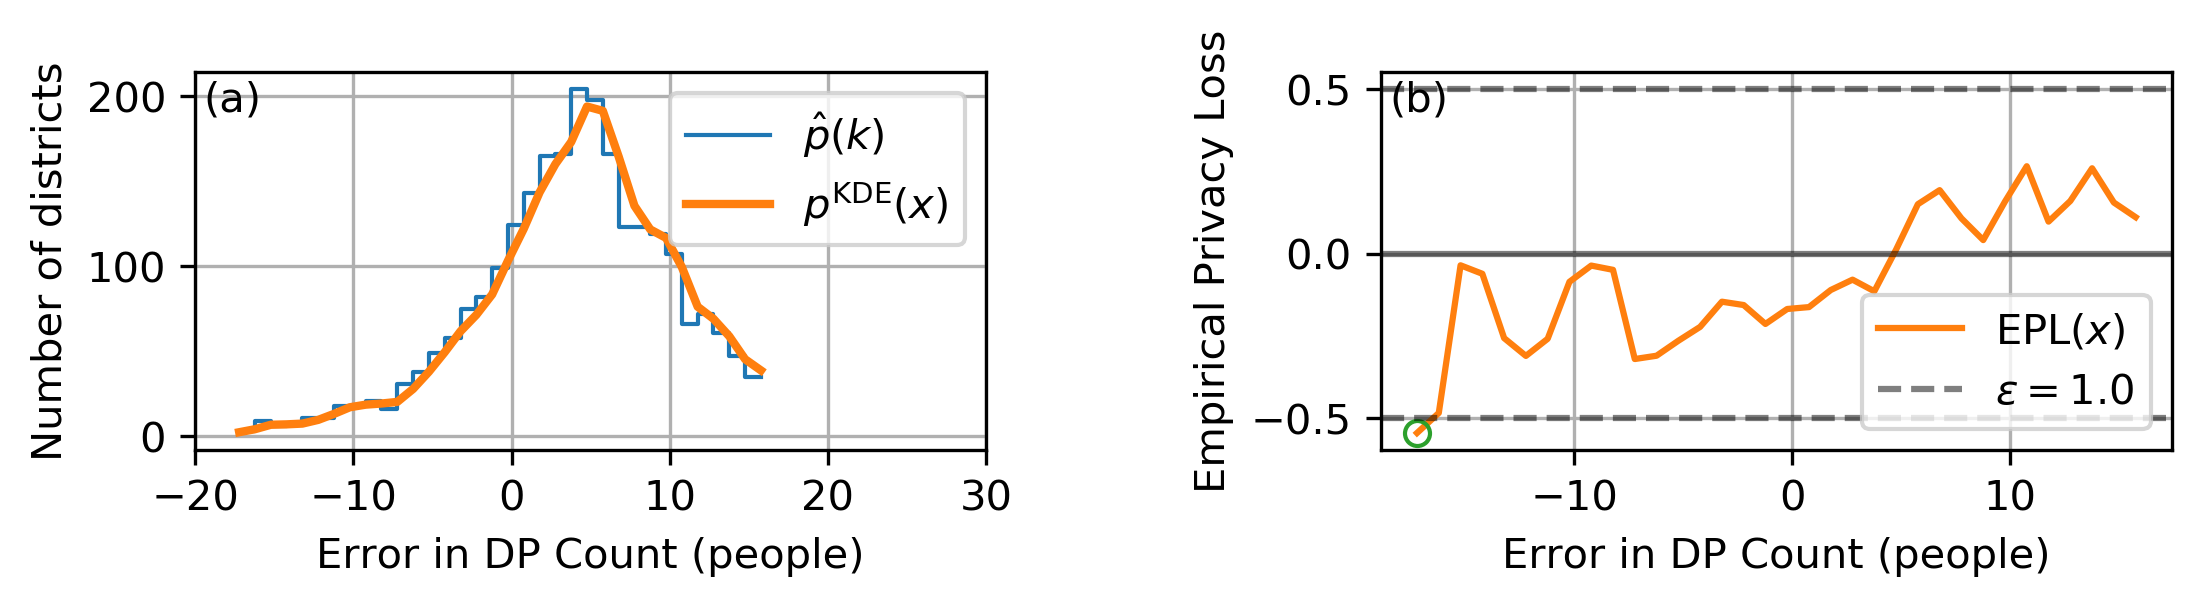

In [20]:
def my_plot(df_epl):
    fig, ax = plt.subplots(ncols=2, figsize=(8.5, 2), dpi=300)
    
    ax[0].plot(df_epl['hist'], linewidth=1, linestyle='-', label='$\\hat{p}(k)$', drawstyle='steps')
    ax[0].plot(df_epl['smooth_hist'], linewidth=2, linestyle='-', label='$p^{\\mathrm{KDE}}(x)$')
    
    ax[0].set_ylabel('Number of districts')
    ax[0].set_xlabel('Error in DP Count (people)')
    ax[0].set_xlim(-20,30)
    ax[0].grid()
    ax[0].text(.01, .98, '(a)', transform=ax[0].transAxes, ha='left', va='top')
    ax[0].legend(loc='upper right')

    ax[1].plot(df_epl['smooth_epl'], linestyle='-', color='C1', label='$\\mathrm{EPL}(x)$')
    xx = np.absolute(df_epl.smooth_epl).idxmax()
    yy = np.absolute(df_epl.smooth_epl).max()
    ax[1].plot([xx], [-yy], 'o', color='none', mec='C2', mew=1)
    
    ax[1].set_ylabel('Empirical Privacy Loss')
    ax[1].set_xlabel('Error in DP Count (people)')
    ax[1].axhline(0, color='k', alpha=.5)
    ax[1].axhline(epsilon/2, color='k', linestyle='--', alpha=.5, label=f'$\\epsilon = {epsilon}$')
    ax[1].axhline(-epsilon/2, color='k', linestyle='--', alpha=.5)
    ax[1].grid()
    ax[1].text(.01, .98, '(b)', transform=ax[1].transAxes, ha='left', va='top')
    ax[1].legend(loc='lower right')
    
    plt.subplots_adjust(wspace=.5, bottom=.25)

my_plot(df_epl)
plt.savefig('fig_SA3_hist_epl.png')

In [21]:
np.absolute(df_epl.smooth_epl).max()

0.5440714549808033

In [22]:
2*np.percentile(np.absolute(df_epl.smooth_epl), 50)

0.31519188227711326

In [23]:
# set randoms seed for reproducibility
np.random.seed(12345)

results = []

for epsilon_1 in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
    for epsilon_2 in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:

        total_cnt_gdpc = dp_2020_census.model.GDPC(epsilon_1/2, total_cnt_orig)

        strat_cnt_gdpc = dp_2020_census.model.GDPC(epsilon_2/2, strat_cnt_orig)

        total_cnt_opt = nonneg_optimized_counts(total_cnt_gdpc, strat_cnt_gdpc)
        error = total_cnt_opt - total_cnt_orig

        df_epl = dp_2020_census.model.empirical_privacy_loss(
            error, bandwidth=0.1, est_range_percentile=95, est_range_multiplier=1.0)
        
        results.append(dict(epsilon_1=epsilon_1, epsilon_2=epsilon_2,
                           epl=#2*np.percentile(np.absolute(df_epl.smooth_epl), 50)
                            np.absolute(df_epl.smooth_epl).max()
                           ))
results = pd.DataFrame(results)
results

/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:78: RuntimeWarning: divide by zero encountered in true_divide
  ratio = f_empirical[:-1] / f_empirical[1:]
/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:78: RuntimeWarning: invalid value encountered in true_divide
  ratio = f_empirical[:-1] / f_empirical[1:]
/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:82: RuntimeWarning: divide by zero encountered in log
  df['epl_hist'] = np.log(ratio)


,epsilon_1,epsilon_2,epl
0,0.1,0.1,5.721971
1,0.1,0.2,1.011611
2,0.1,0.3,0.219830
3,0.1,0.4,0.284091
4,0.1,0.5,0.212881
...,...,...,...
76,0.9,0.5,56.568667
77,0.9,0.6,46.466262
78,0.9,0.7,43.116511
79,0.9,0.8,33.396272


In [24]:
results['epsilon'] = results.epsilon_1 + results.epsilon_2

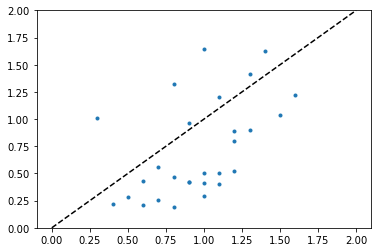

In [25]:
plt.plot(results.epsilon, results.epl, '.')
plt.plot([0,2], [0,2], 'k--')
plt.axis(ymin=0, ymax=2);